In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.fft import fft, ifft, fftfreq, fftshift, ifftshift
import librosa
import soundfile as sf
%matplotlib widget

Util-функции

In [2]:
def draw_plots(rows, cols, width, height, subplot_data, legend_loc="best", legend_fontsize="small"):
    fig, axes = plt.subplots(rows, cols, figsize=(width, height))
    axes = axes.flatten() if rows * cols > 1 else [axes]

    flat_data = [item for row in subplot_data for item in row]

    for idx, data in enumerate(flat_data):
        if idx >= len(axes):
            raise ValueError(f"Too many subplots provided in 'subplot_data': expected at most {rows * cols}, got more.")
        if not data:
            continue

        ax = axes[idx]

        (
            x_arrays, y_arrays,
            labels,
            x_label, y_label,
            colors, linestyles,
            linewidth, markers,
            markersizes, title,
            markerevery
        ) = data + [None] * (12 - len(data))

        num_plots = len(y_arrays)

        for i in range(num_plots):
            x = x_arrays[i]
            y = y_arrays[i]

            label = labels[i] if labels and i < len(labels) else None
            color = colors[i] if colors and i < len(colors) else None
            linestyle = linestyles[i] if linestyles and i < len(linestyles) else '-'
            lw = linewidth[i] if linewidth and i < len(linewidth) else 2
            marker = markers[i] if markers and i < len(markers) else None
            markersize = markersizes[i] if markersizes and i < len(markersizes) else None
            mevery = markerevery[i] if markerevery and i < len(markerevery) else None

            ax.plot(x, y,
                    label=label,
                    color=color,
                    linestyle=linestyle,
                    linewidth=lw,
                    marker=marker,
                    markersize=markersize,
                    markevery=mevery)

        if labels:
            ax.legend(loc=legend_loc, fontsize=legend_fontsize)
        ax.grid(True)
        if x_label:
            ax.set_xlabel(x_label)
        if y_label:
            ax.set_ylabel(y_label)
        if title:
            ax.set_title(title)
    
    for idx in range(len(flat_data), len(axes)):
        fig.delaxes(axes[idx])
        
    plt.gca().set_axisbelow(True) 
    plt.tight_layout()
    plt.show()

In [3]:
g = lambda t: 17 if (1 <= t <= 8) else 0
u = lambda t, b, c, d: g(t) + b * np.random.uniform(-1, 1) + c * np.sin(d * t)

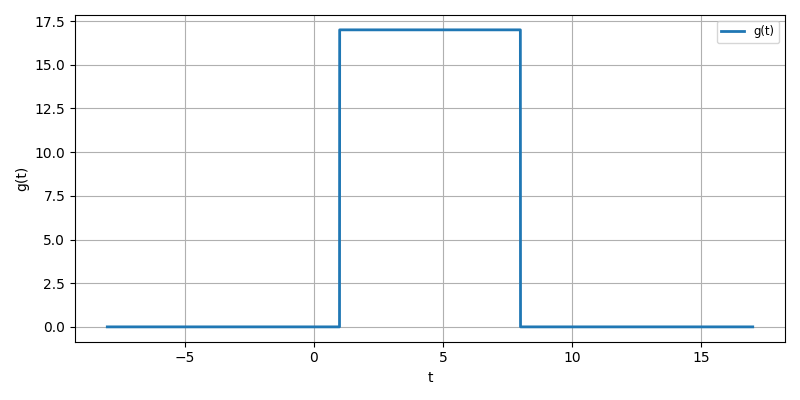

In [4]:
t_space_1 = np.linspace(-8, 17, 4048)
g_1 = [g(t) for t in t_space_1]

draw_plots(1, 1, 8, 4, [[[
    [t_space_1],
    [g_1],
    ['g(t)'],
    't', 'g(t)'
]]])

# Задание 1.1

In [5]:
c = 0
d = 1
b_array = (2, 5, 10)
nu_array = (0.45, 1.0, 2.0)

subplot_data = []

dt = t_space_1[1] - t_space_1[0]
N = 2 ** 14

g_hat = fftshift(fft(g_1, n=N))
freqs = fftshift(fftfreq(N, d=dt))
subplot_data_Fourier_nu = []
subplot_data_signal = []

for b in b_array:
    ub = [u(t, b, c, d) for t in t_space_1]
    
    subplot_data.append([[
        [t_space_1],
        [ub],
        [f"b = {b}"],
        "t",
        "u(t)",
        ["green"],
        [None],
        [0.8]
    ]])

    ub_hat = fftshift(fft(ub, n=N))
    freq_mask = (np.abs(freqs) <= 3)
    subplot_data_Fourier_nu_b = []
    subplot_data_signal_b = []
    for nu in nu_array:
        ub_catted = np.where((freqs >= -nu) & (freqs <= nu), ub_hat, 0)
        subplot_data_Fourier_nu_b.append([
            [freqs[freq_mask]] * 3,
            [
            2.0 / N * np.abs(g_hat)[freq_mask],
            2.0 / N * abs(ub_hat)[freq_mask],
            2.0 / N * np.abs(ub_catted)[freq_mask]
            ],
            ["g^(v)", "u^(v)", "u^(v)[-v0;v0]"],
            "v",
            "f(v)",
            ["green", "red", "blue"] * 3,
            ["-", "-", "-"],
            [0.9] * 3,
            [None] * 3,
            [None] * 3,
            f"v0 = {nu}, b = {b}"
        ])
        ub_filtered = np.real(ifft(fftshift(ub_catted)))[:len(t_space_1)]
        subplot_data_signal_b.append([
            [t_space_1] * 3,
            [ub, g_1, ub_filtered],
            ["u(t)", "g(t)", f"u_filtered(t), v0={nu}"],
            "t",
            "Signal(t)",
            ["green", "red", "blue"],
            ["-", "-", "-"],
            [1.5] * 3,
            [None] * 3,
            [None] * 3,
            f"b = {b}, v0 = {nu}"
        ])

    subplot_data_Fourier_nu.append(subplot_data_Fourier_nu_b)
    subplot_data_signal.append(subplot_data_signal_b)

#### Нарисуем графики

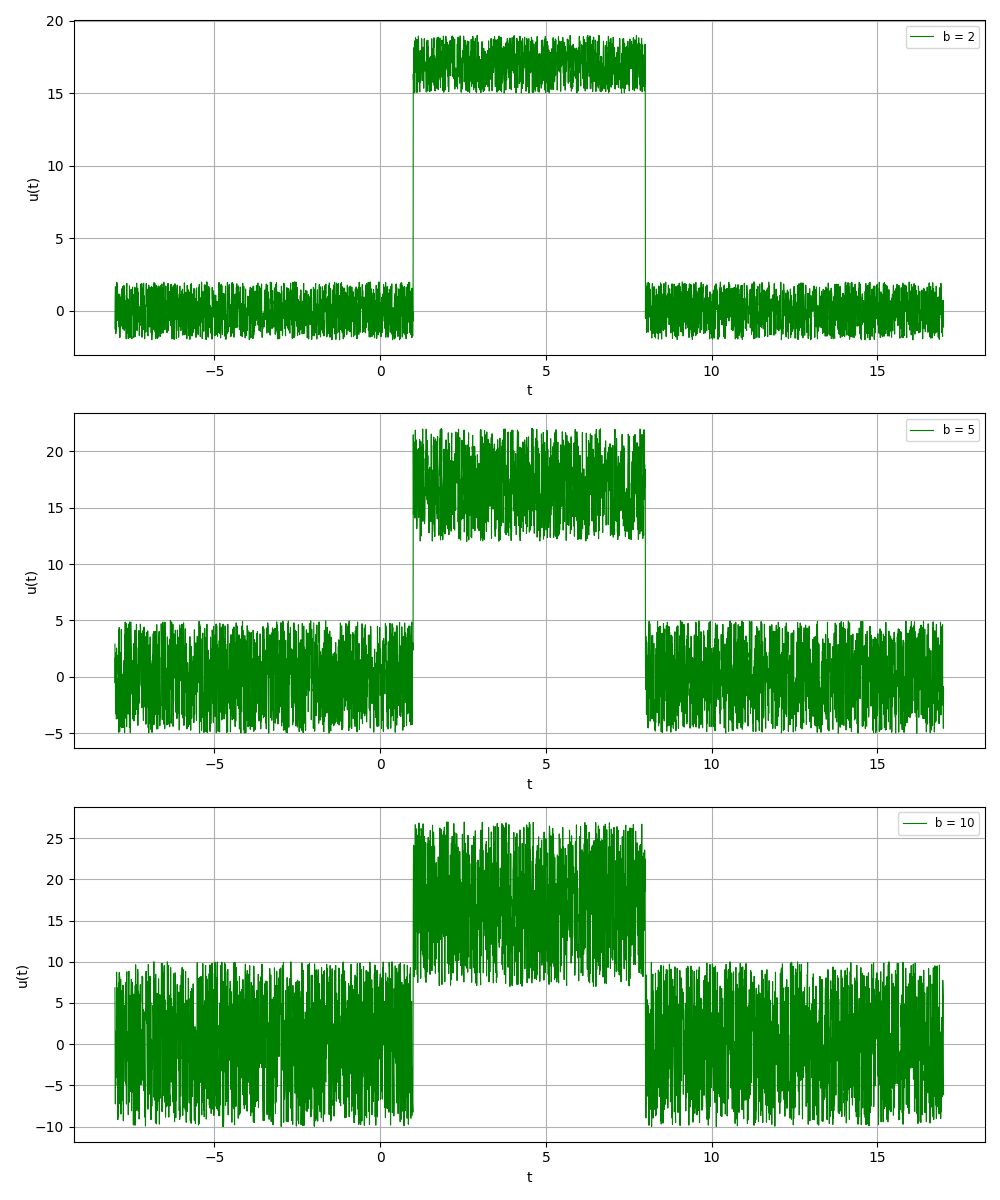

In [6]:
draw_plots(
    rows=3,
    cols=1,
    width=10,
    height=12,
    subplot_data=subplot_data
)

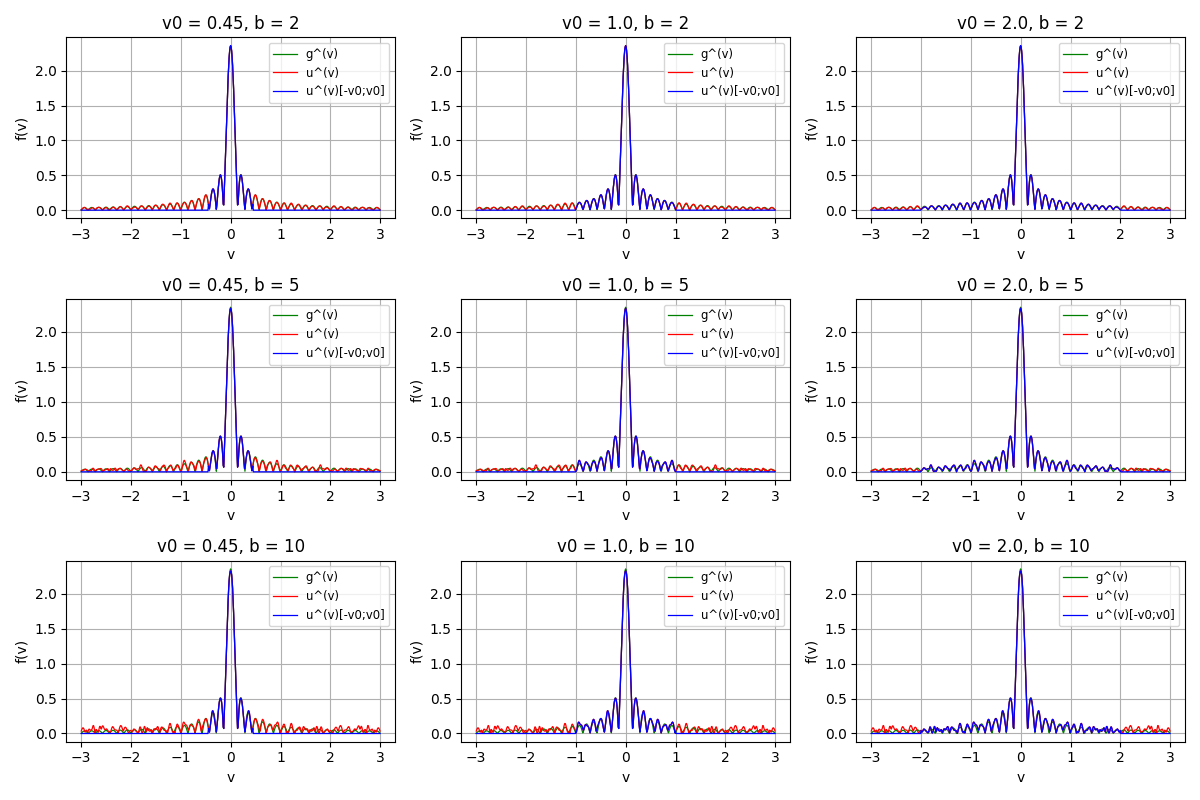

In [7]:
draw_plots(
    rows=3,
    cols=3,
    width=12,
    height=8,
    subplot_data=subplot_data_Fourier_nu
)

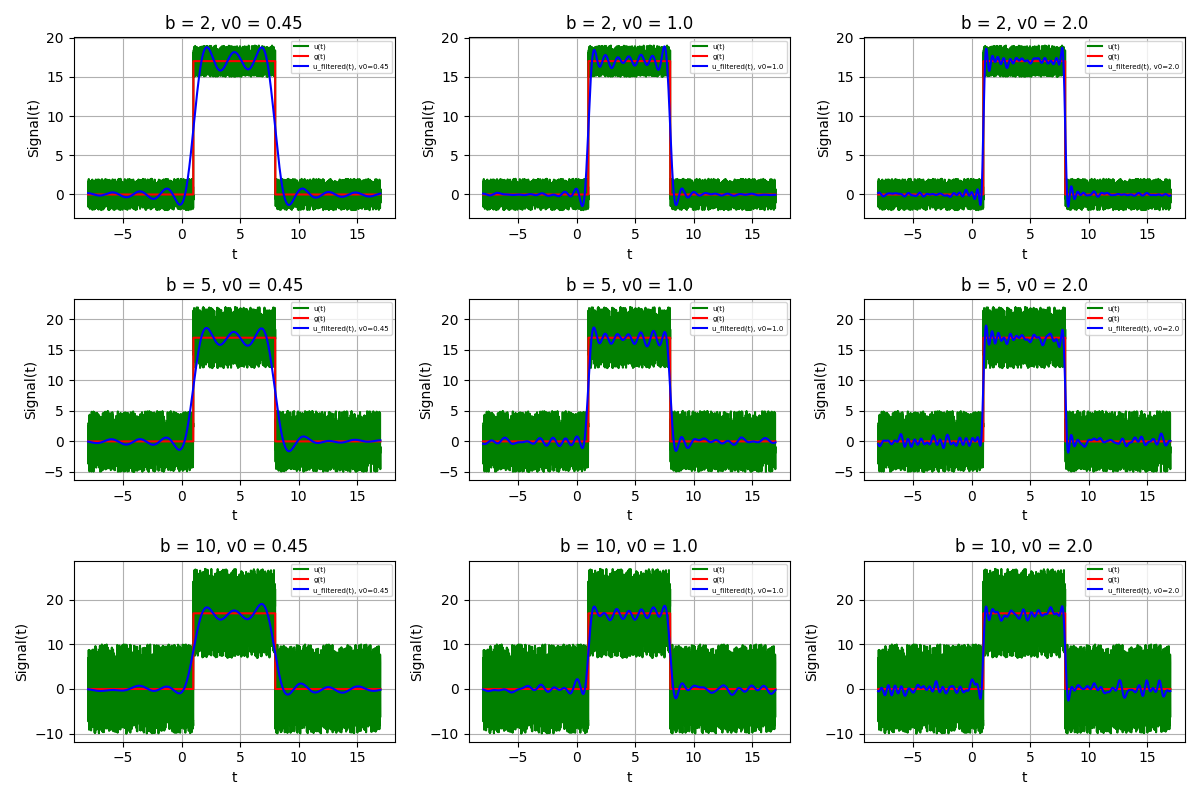

In [8]:
draw_plots(
    rows=3,
    cols=3,
    width=12,
    height=8,
    subplot_data=subplot_data_signal,
    legend_loc="upper right",
    legend_fontsize=5
)

# Задание 1.2

In [9]:
b_values = [2, 8]
c_values = [1, 6]
d_values = [1, 3, 8]
nu_ranges = [0.4, 1.0, 2.0]

dt = t_space_1[1] - t_space_1[0]
N = 2 ** 15

freqs = fftshift(fftfreq(N, d=dt))
g_hat = fftshift(fft(g_1, n=N))

plots_2 = []
for nu_range in nu_ranges:
    subplot_data_signal_12 = []
    subplot_data_fourier_12 = []

    for b in b_values:
        for c in c_values:
            subplot_data_signal_12_c = []
            subplot_data_fourier_12_c = []
            for d in d_values:
                u_signal = [u(t, b, c, d) for t in t_space_1]
                u_hat = fftshift(fft(u_signal, n=N))

                harmonic_mask = (np.abs(freqs - d/2/np.pi) > 0.02) & (np.abs(freqs + d/2/np.pi) > 0.02)
                lowpass_mask = (np.abs(freqs) <= nu_range)
                combined_mask = lowpass_mask & harmonic_mask

                u_hat_filtered = np.where(combined_mask, u_hat, 0)
                u_filtered = np.real(ifft(fftshift(u_hat_filtered)))[:len(t_space_1)]

                freq_mask = np.abs(freqs) <= 3
                subplot_data_fourier_12_c.append([
                    [freqs[freq_mask]] * 3,
                    [
                        2.0 / N * np.abs(g_hat)[freq_mask],
                        2.0 / N * np.abs(u_hat)[freq_mask],
                        2.0 / N * np.abs(u_hat_filtered)[freq_mask]
                    ],
                    ["g^(v)", "u^(v)", "u_filtered^(v)"],
                    "v",
                    "f(v)",
                    ["green", "red", "blue"],
                    ["-", "-", "-"],
                    [1.0] * 3,
                    [None] * 3,
                    [None] * 3,
                    f"v0 = {nu_range}, b={b}, c={c}, d={d}"
                ])

                subplot_data_signal_12_c.append([
                    [t_space_1] * 3,
                    [u_signal, g_1, u_filtered],
                    ["u(t)", "g(t)", "u_filtered(t)"],
                    "t",
                    "Signal",
                    ["green", "red", "blue"],
                    ["-", "-", "-"],
                    [1.5] * 3,
                    [None] * 3,
                    [None] * 3,
                    f"v0 = {nu_range}, b={b}, c={c}, d={d}"
                ])

            subplot_data_signal_12.append(subplot_data_signal_12_c)
            subplot_data_fourier_12.append(subplot_data_fourier_12_c)
    
    plots_2.append([subplot_data_fourier_12, subplot_data_signal_12])

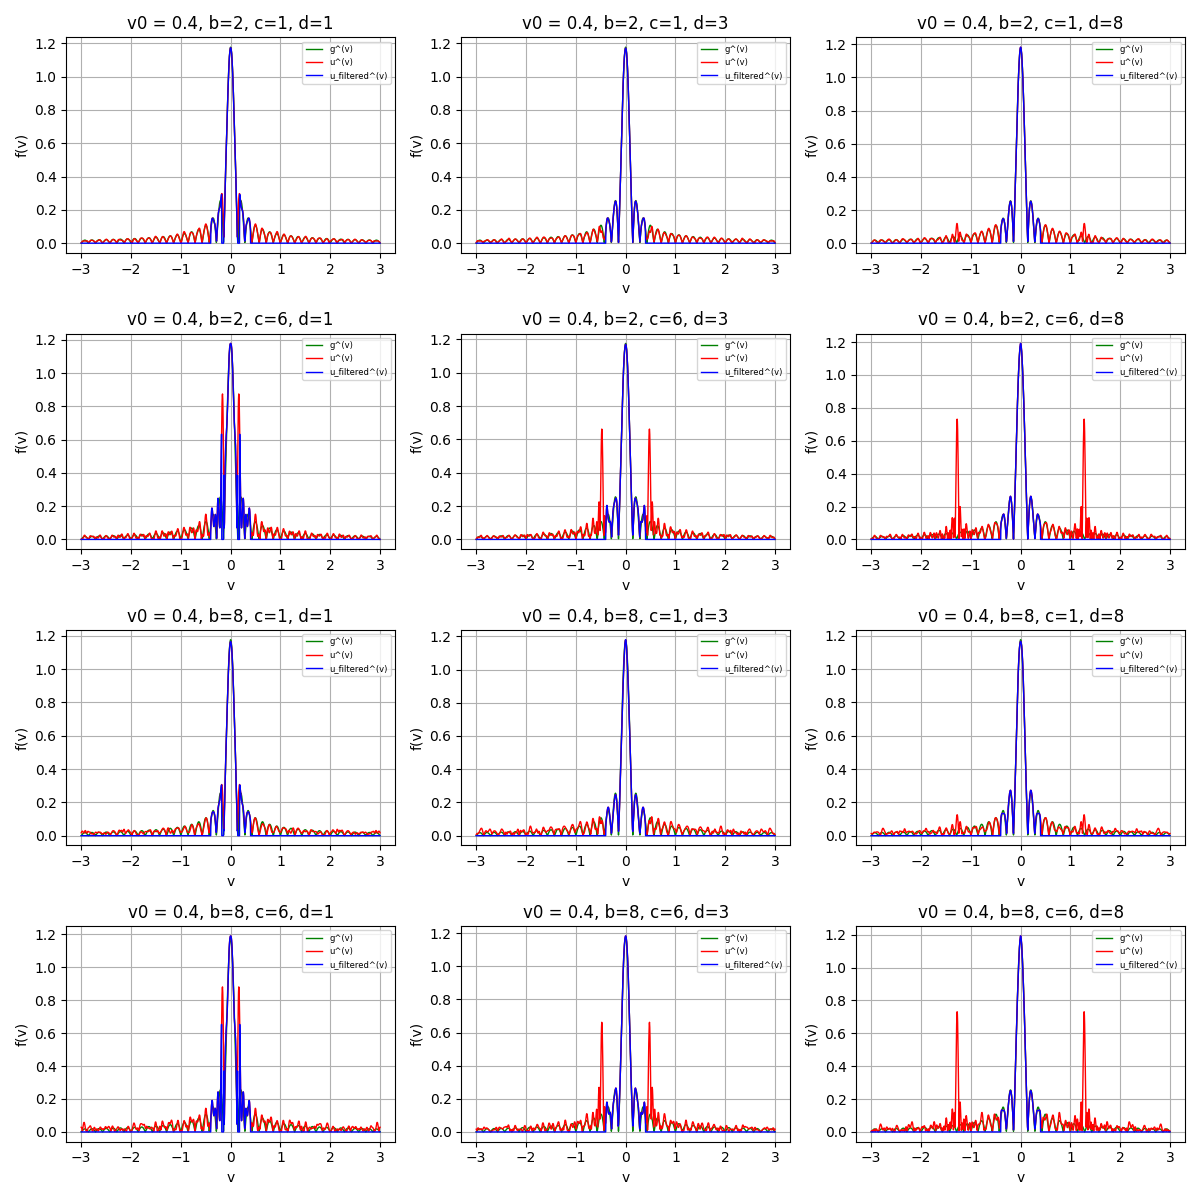

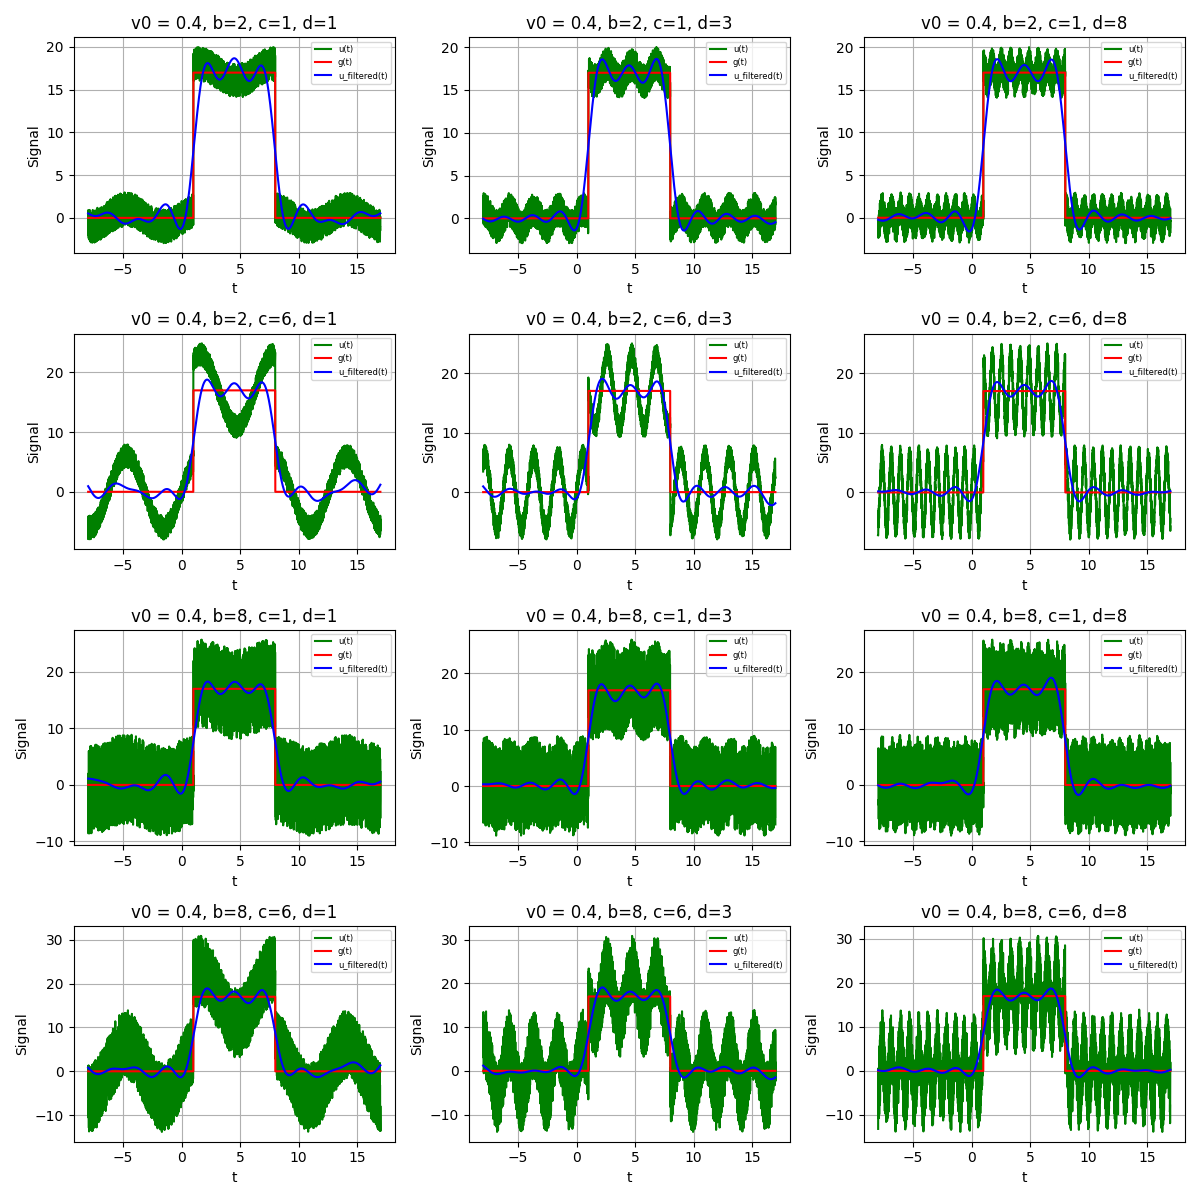

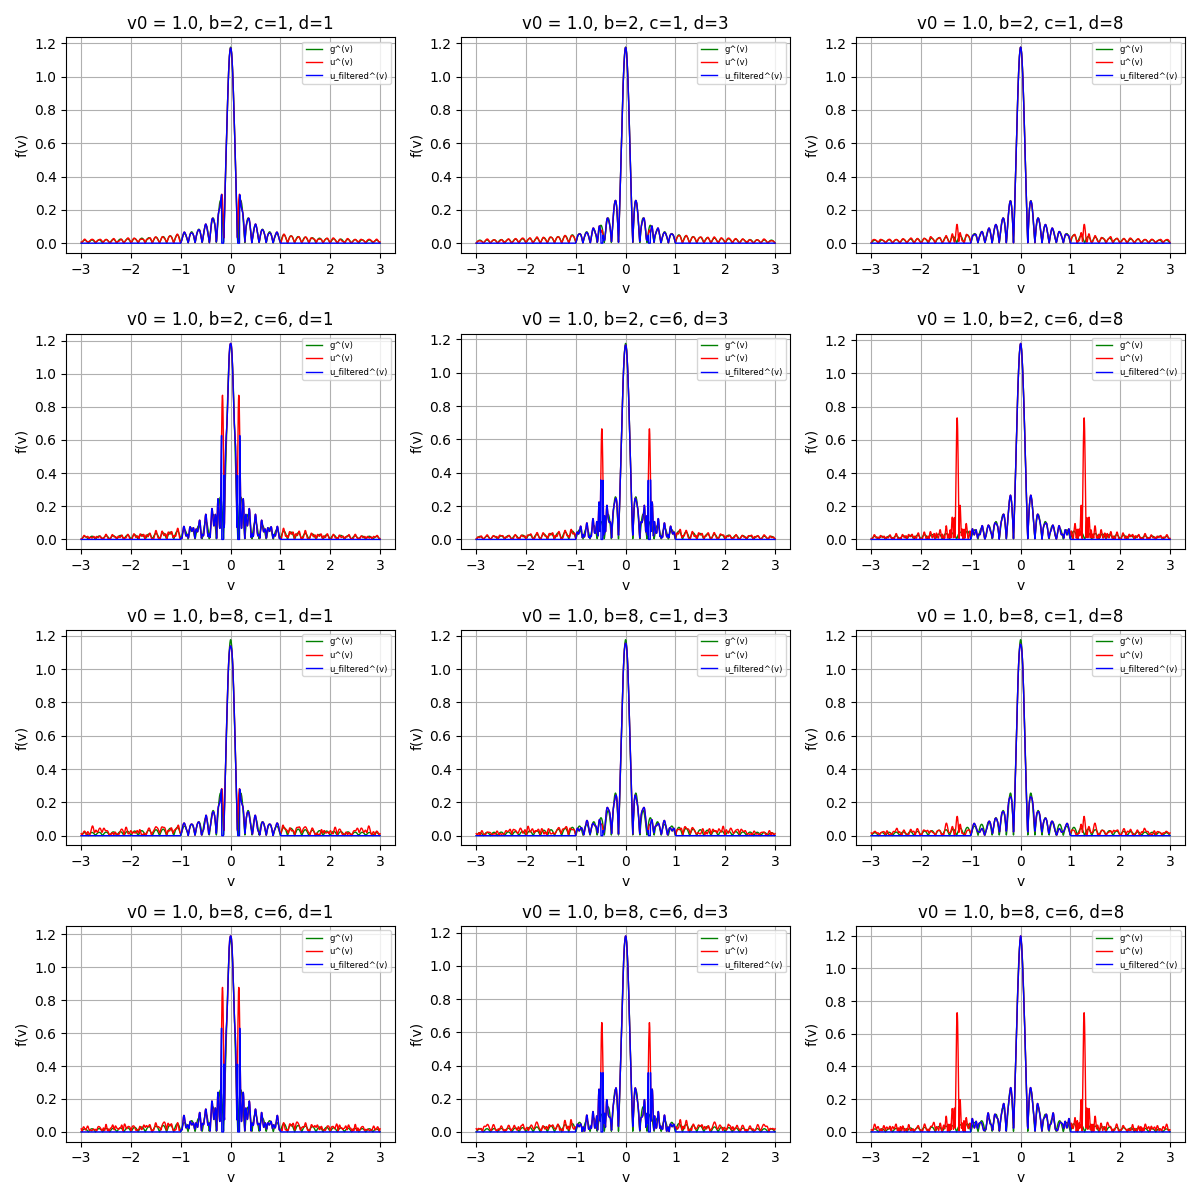

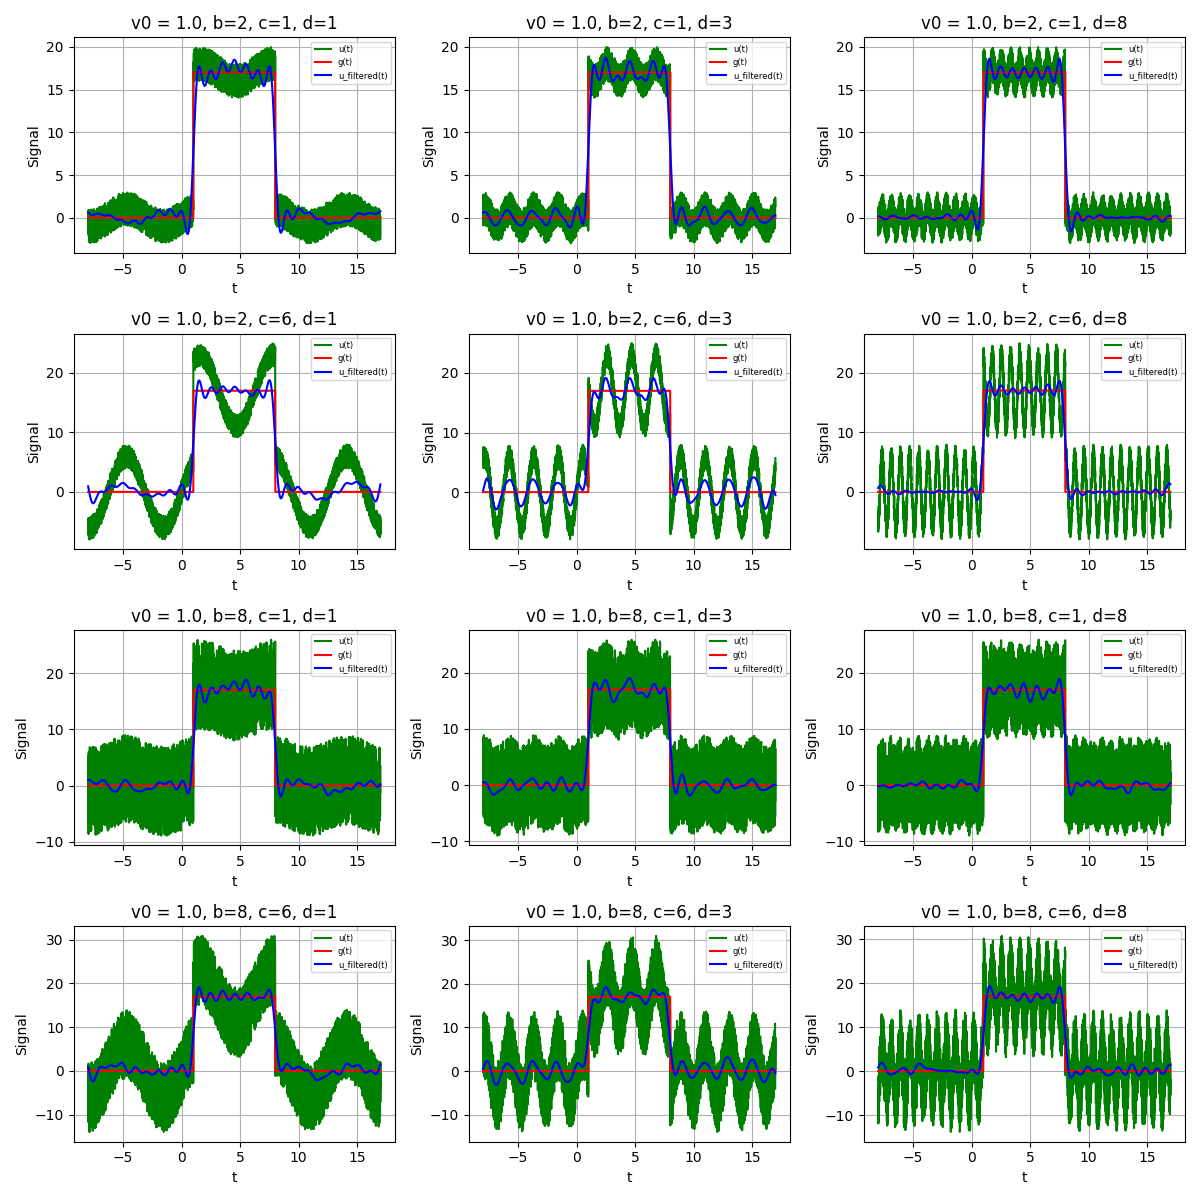

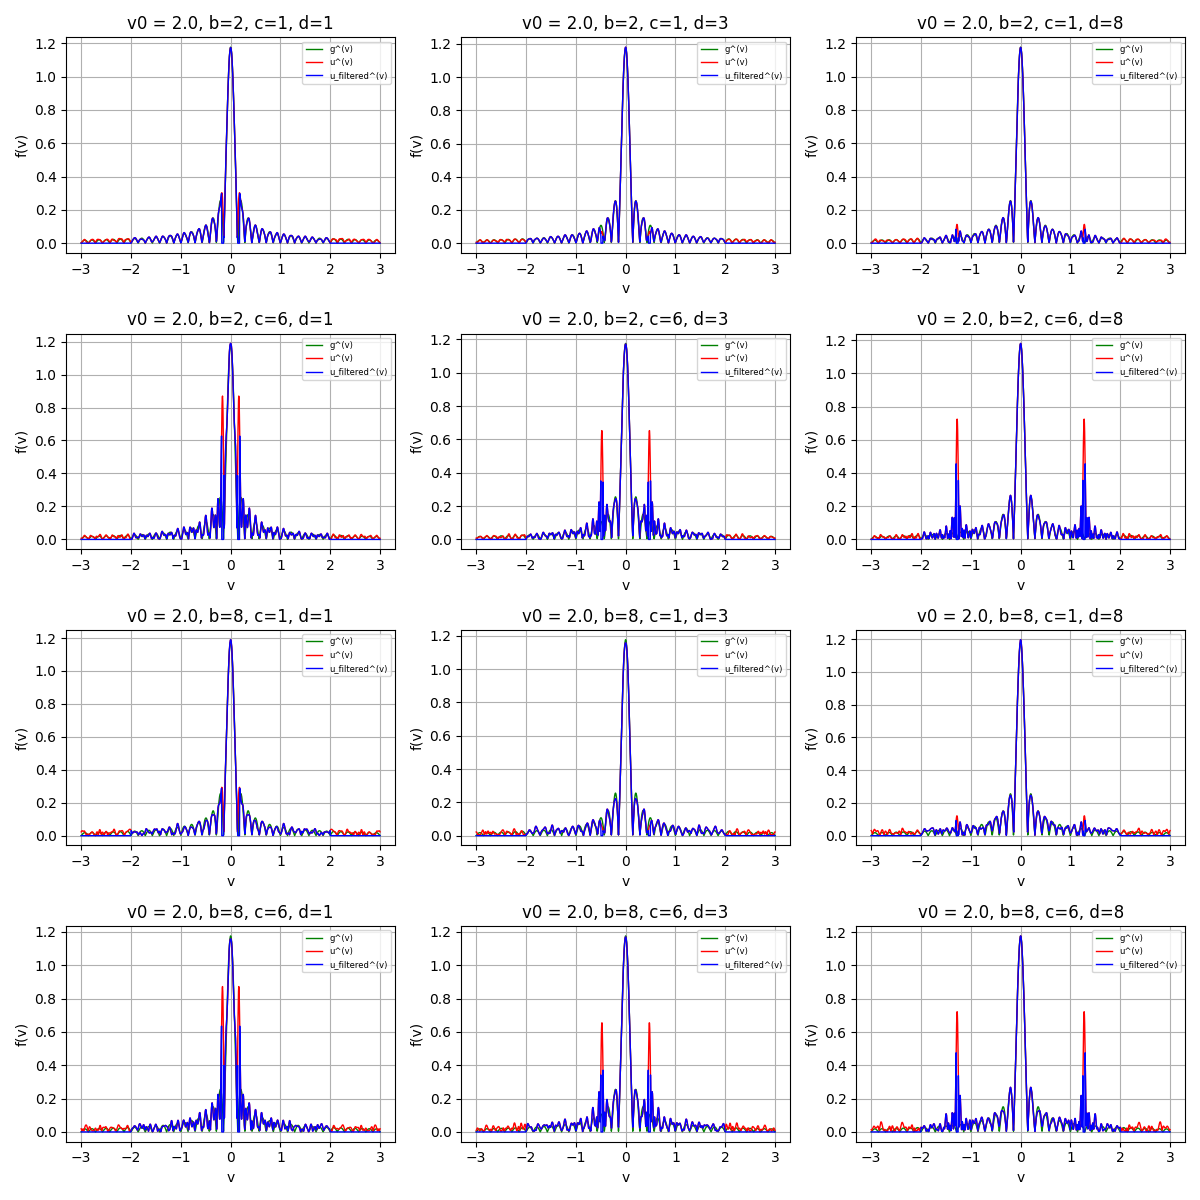

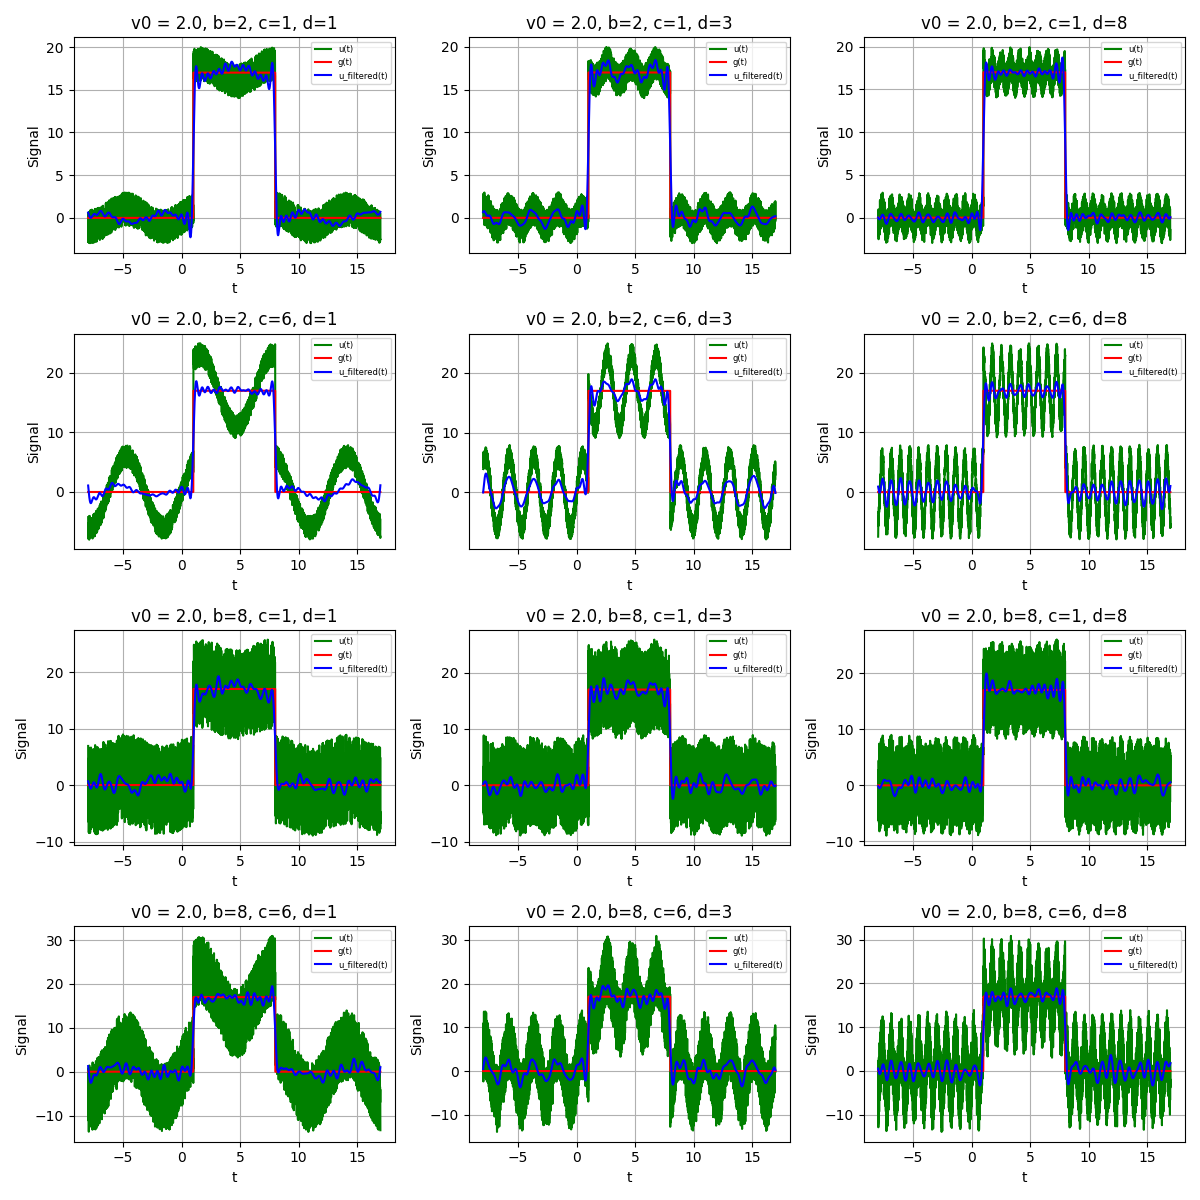

In [10]:
for subplot_data_fourier_12, subplot_data_signal_12 in plots_2:
    draw_plots(
        rows=4,
        cols=3,
        width=12,
        height=12,
        subplot_data=subplot_data_fourier_12,
        legend_loc="upper right",
        legend_fontsize=6
    )
    draw_plots(
        rows=4,
        cols=3,
        width=12,
        height=12,
        subplot_data=subplot_data_signal_12,
        legend_loc="upper right",
        legend_fontsize=6
    )

#### b=0

In [11]:
b = 0
nu_ranges = [0.3, 1.0, 2.8]

plots_2_2 = []
for nu_range in nu_ranges:
    subplot_data_signal_12 = []
    subplot_data_fourier_12 = []

    for c in c_values:
        subplot_data_signal_12_c = []
        subplot_data_fourier_12_c = []
        for d in d_values:
            u_signal = [u(t, b, c, d) for t in t_space_1]
            u_hat = fftshift(fft(u_signal, n=N))

            harmonic_mask = (np.abs(freqs - d/2/np.pi) > 0.015 * d ** 1.5) & (np.abs(freqs + d/2/np.pi) > 0.015 * d ** 1.5)
            lowpass_mask = (np.abs(freqs) <= nu_range)
            combined_mask = lowpass_mask & harmonic_mask

            u_hat_filtered = np.where(combined_mask, u_hat, 0)
            u_filtered = np.real(ifft(fftshift(u_hat_filtered)))[:len(t_space_1)]

            freq_mask = np.abs(freqs) <= 3
            subplot_data_fourier_12_c.append([
                [freqs[freq_mask]] * 3,
                [
                    2.0 / N * np.abs(g_hat)[freq_mask],
                    2.0 / N * np.abs(u_hat)[freq_mask],
                    2.0 / N * np.abs(u_hat_filtered)[freq_mask]
                ],
                ["g^(v)", "u^(v)", "u_filtered^(v)"],
                "v",
                "f(v)",
                ["green", "red", "blue"],
                ["-", "-", "-"],
                [1.0] * 3,
                [None] * 3,
                [None] * 3,
                f"v0 = {nu_range}, b={b}, c={c}, d={d}"
            ])

            subplot_data_signal_12_c.append([
                [t_space_1] * 3,
                [u_signal, g_1, u_filtered],
                ["u(t)", "g(t)", "u_filtered(t)"],
                "t",
                "Signal",
                ["green", "red", "blue"],
                ["-", "-", "-"],
                [1.5] * 3,
                [None] * 3,
                [None] * 3,
                f"v0 = {nu_range}, b={b}, c={c}, d={d}"
            ])

        subplot_data_signal_12.append(subplot_data_signal_12_c)
        subplot_data_fourier_12.append(subplot_data_fourier_12_c)
    
    plots_2_2.append([subplot_data_fourier_12, subplot_data_signal_12])

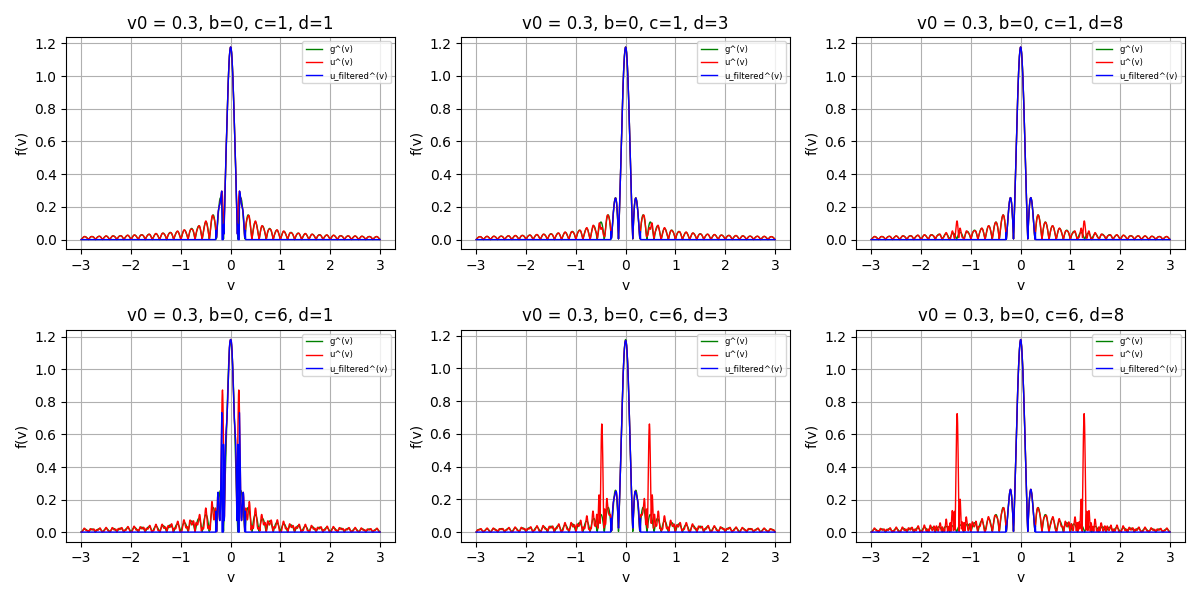

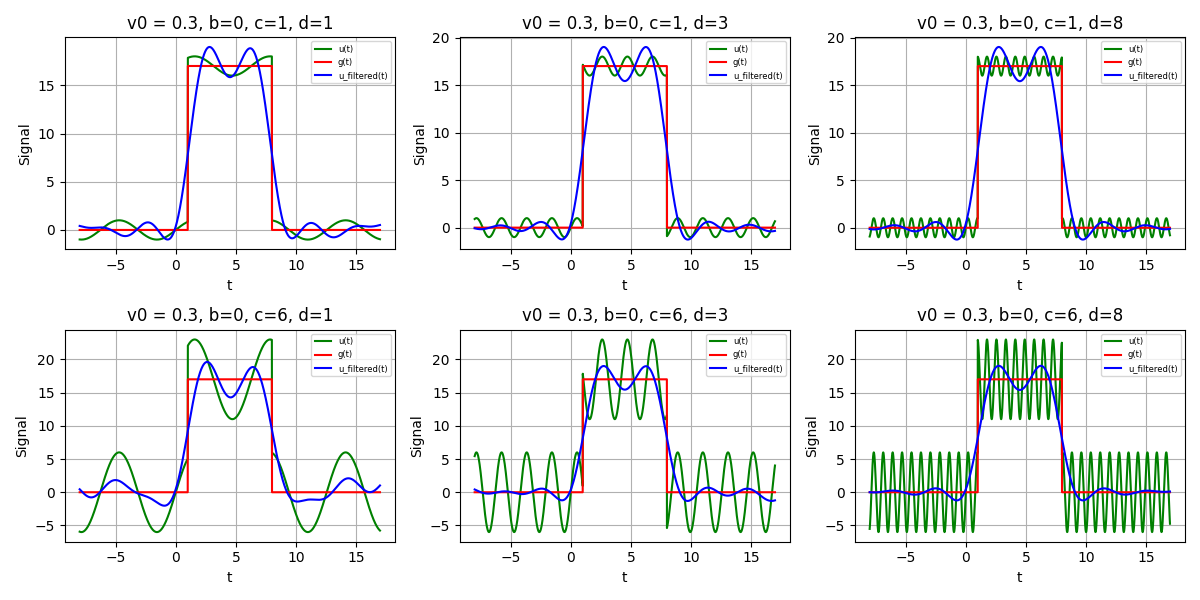

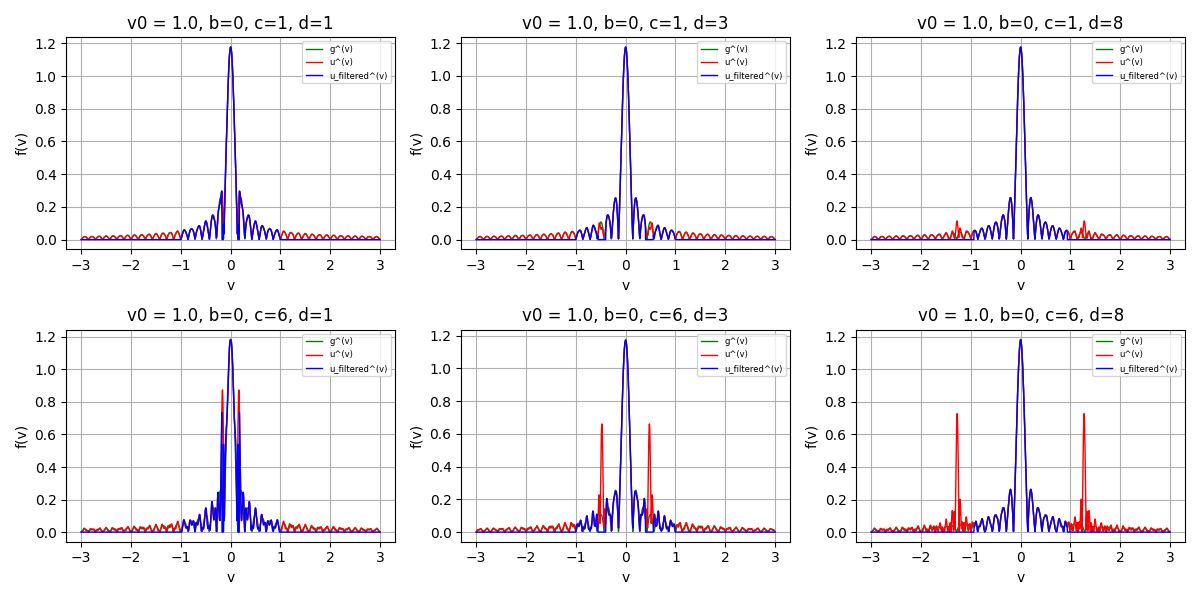

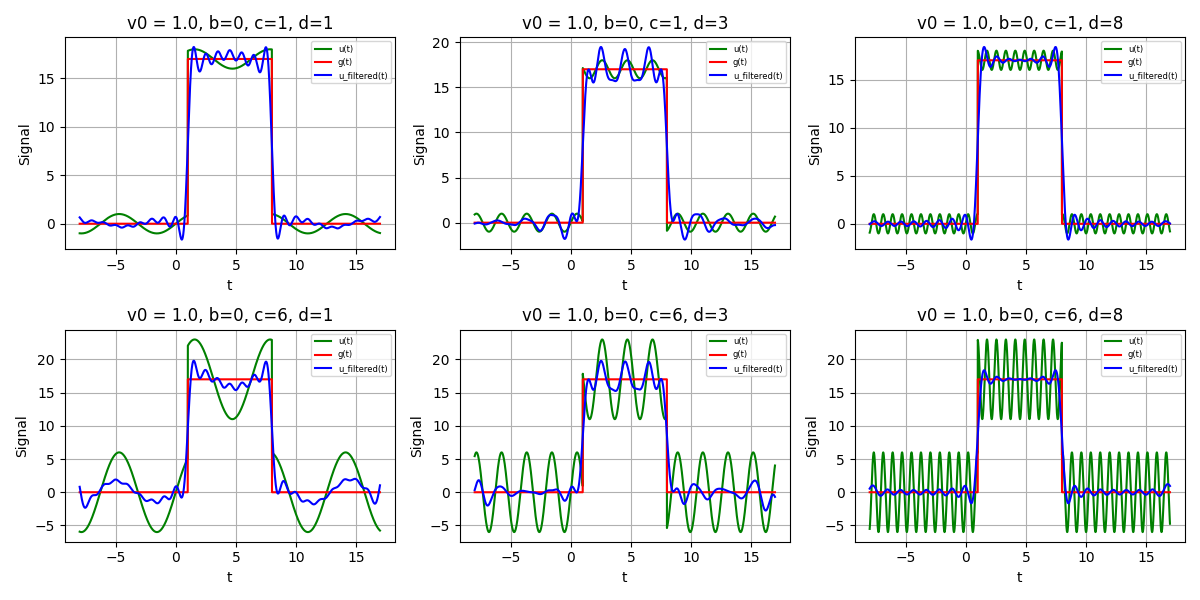

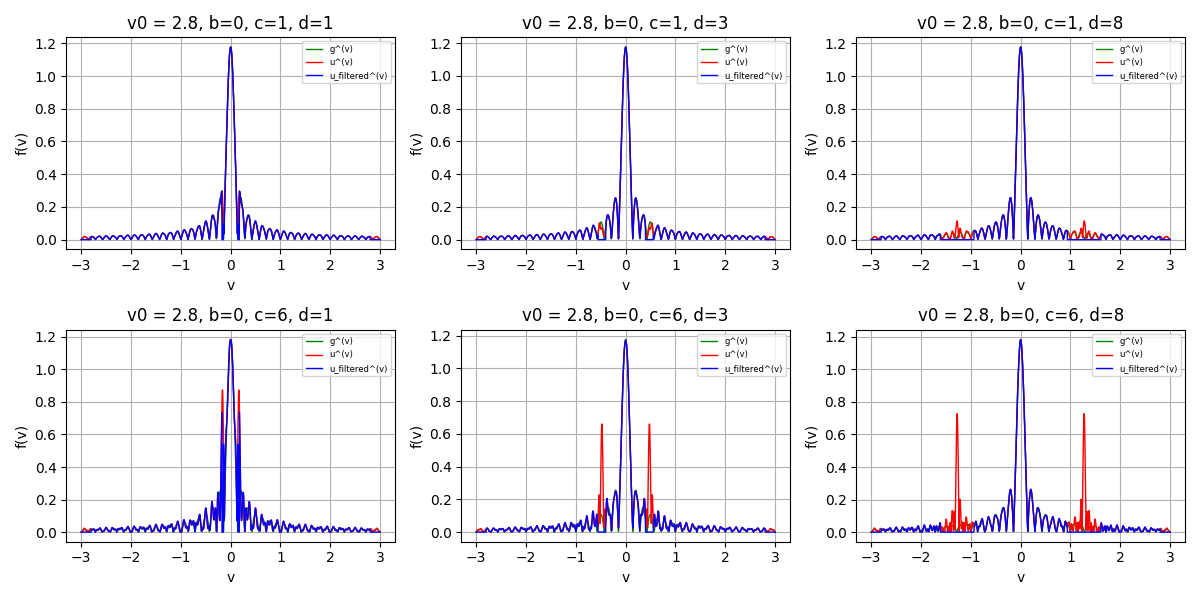

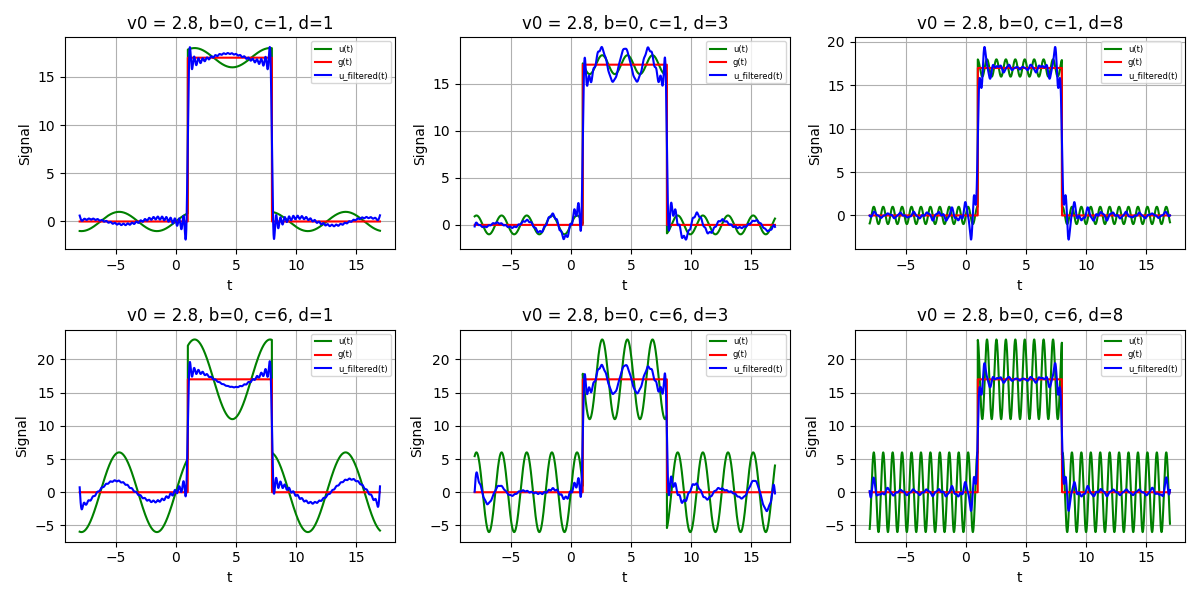

In [12]:
for subplot_data_fourier_12, subplot_data_signal_12 in plots_2_2:
    draw_plots(
        rows=2,
        cols=3,
        width=12,
        height=6,
        subplot_data=subplot_data_fourier_12,
        legend_loc="upper right",
        legend_fontsize=6
    )
    draw_plots(
        rows=2,
        cols=3,
        width=12,
        height=6,
        subplot_data=subplot_data_signal_12,
        legend_loc="upper right",
        legend_fontsize=6
    )

# Задание 1.3

In [13]:
b_values = [1, 4]
c = 2
d_values = [1, 3, 8]
nu_ranges = [0.05, 1.0]

dt = t_space_1[1] - t_space_1[0]
N = 2 ** 13

freqs = fftshift(fftfreq(N, d=dt))
g_hat = fftshift(fft(g_1, n=N))

plots_3 = []

for nu_range in nu_ranges:
    subplot_data_signal_13 = []
    subplot_data_fourier_13 = []
    for b in b_values:
        subplot_data_signal_13_c = []
        subplot_data_fourier_13_c = []
        for d in d_values:
            u_signal = [u(t, b, c, d) for t in t_space_1]
            u_hat = fftshift(fft(u_signal, n=N))

            highpass_mask = (np.abs(freqs) > nu_range)

            u_hat_filtered = np.where(highpass_mask, u_hat, 0)
            u_filtered = np.real(ifft(fftshift(u_hat_filtered)))[:len(t_space_1)]

            freq_mask = np.abs(freqs) <= 3
            subplot_data_fourier_13_c.append([
                [freqs[freq_mask]] * 3,
                [
                    2.0 / N * np.abs(g_hat)[freq_mask],
                    2.0 / N * np.abs(u_hat)[freq_mask],
                    2.0 / N * np.abs(u_hat_filtered)[freq_mask]
                ],
                ["g^(v)", "u^(v)", "u_filtered^(v)"],
                "v",
                "f(v)",
                ["green", "red", "blue"],
                ["-", "-", "-"],
                [1.0] * 3,
                [None] * 3,
                [None] * 3,
                f"v0 = {nu_range}, b={b}, c={c}, d={d}"
            ])

            subplot_data_signal_13_c.append([
                [t_space_1] * 3,
                [u_signal, g_1, u_filtered],
                ["u(t)", "g(t)", "u_filtered(t)"],
                "t",
                "Signal",
                ["green", "red", "blue"],
                ["-", "-", "-"],
                [1.5] * 3,
                [None] * 3,
                [None] * 3,
                f"v0 = {nu_range}, b={b}, c={c}, d={d}"
            ])

        subplot_data_signal_13.append(subplot_data_signal_13_c)
        subplot_data_fourier_13.append(subplot_data_fourier_13_c)
        
    plots_3.append([subplot_data_fourier_13, subplot_data_signal_13])

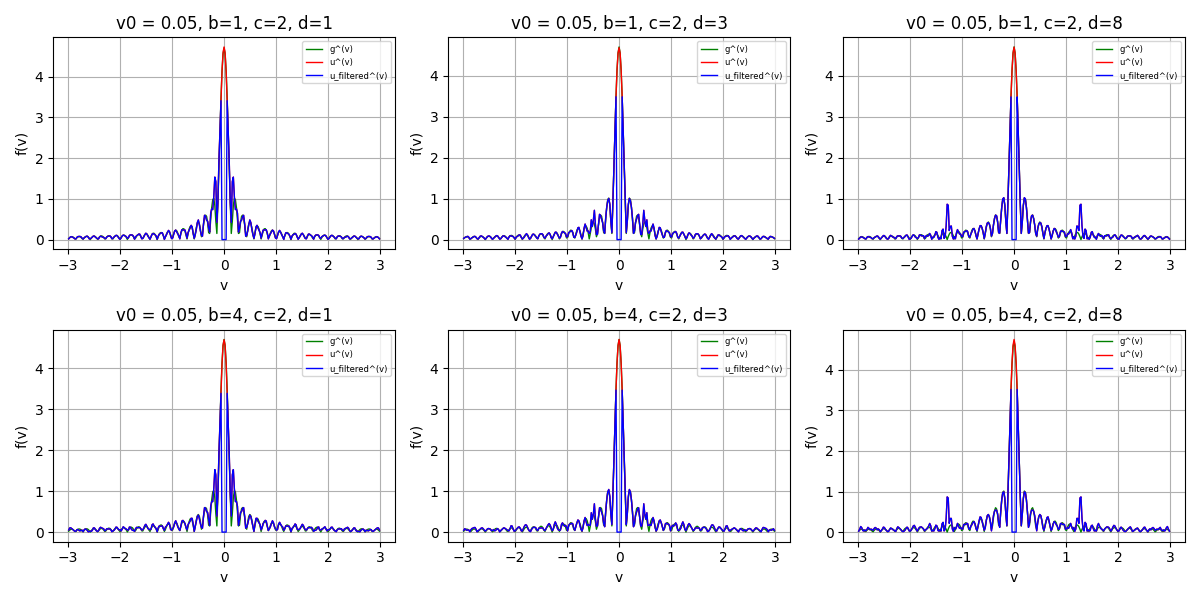

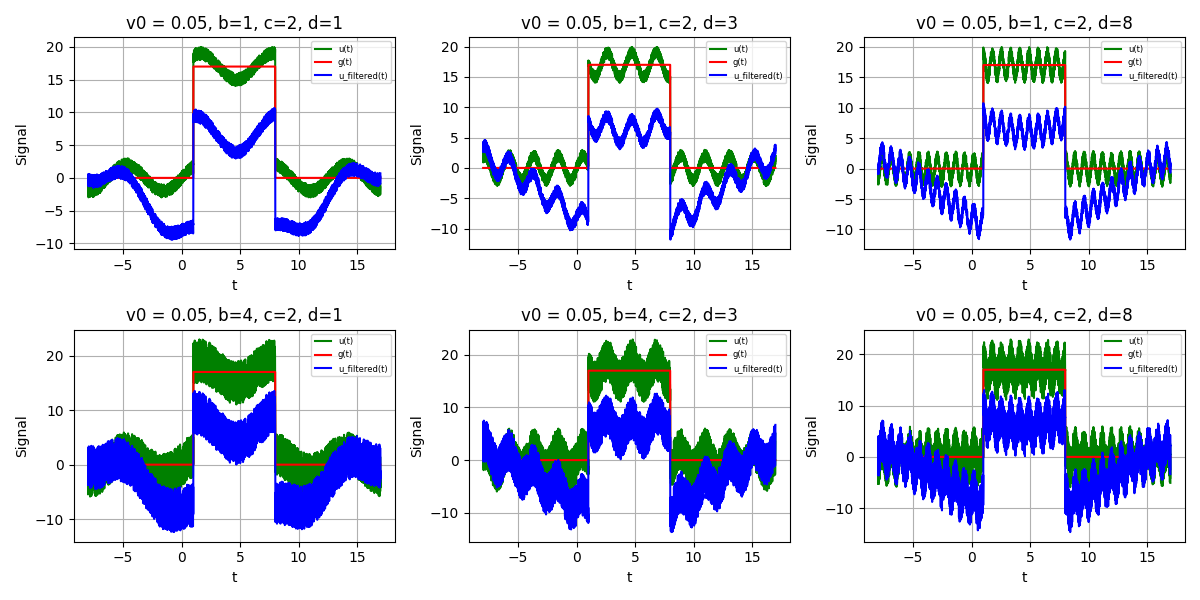

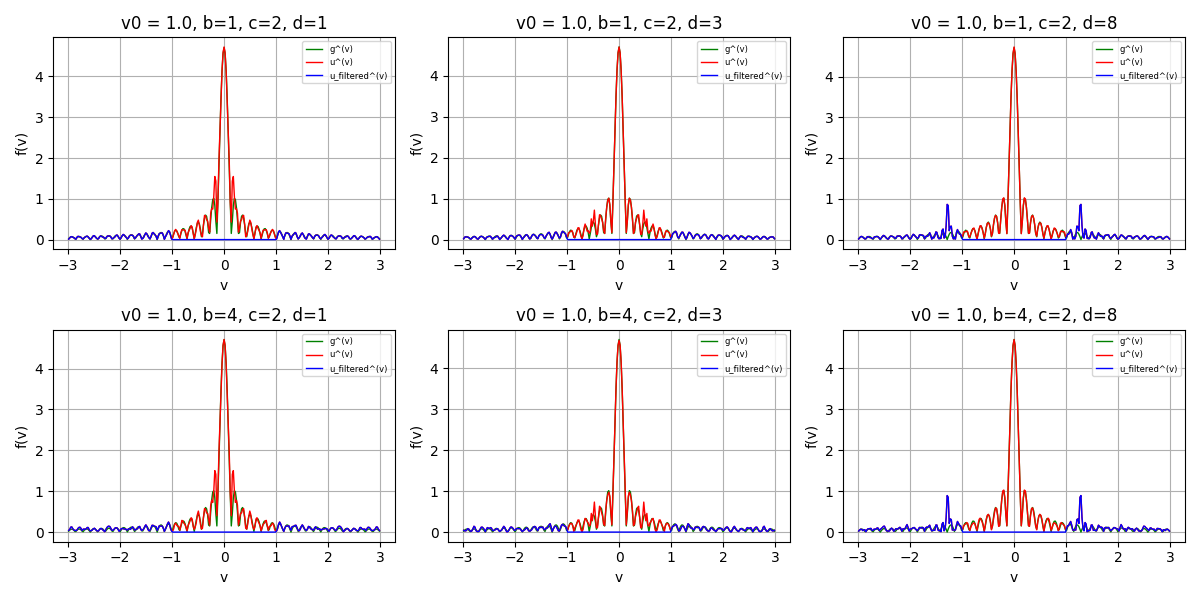

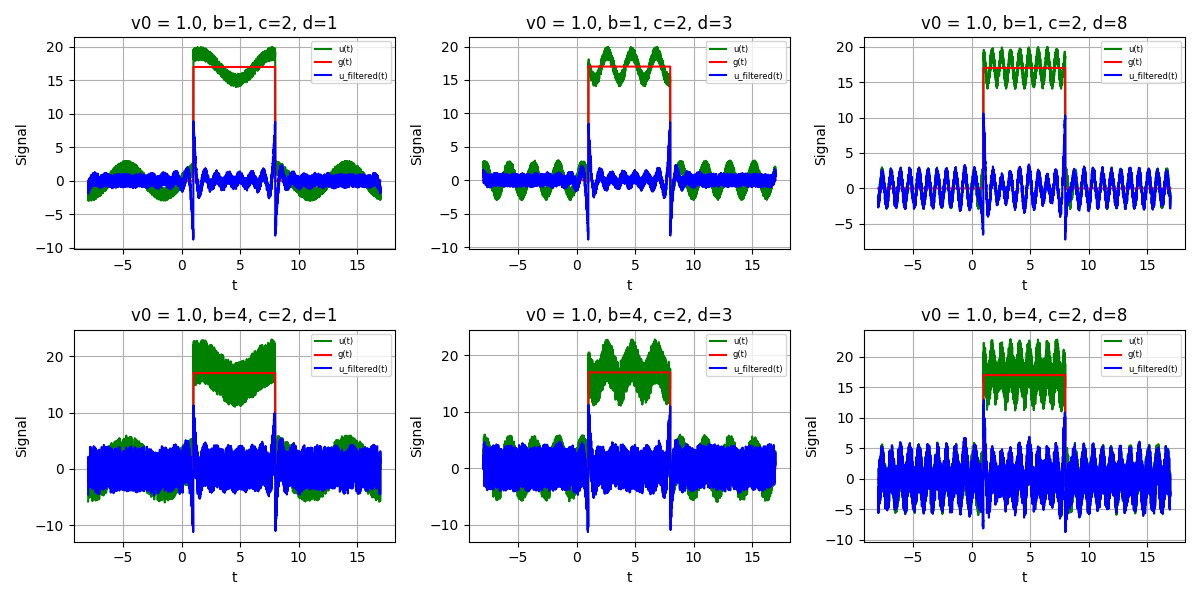

In [14]:
for subplot_data_fourier_13, subplot_data_signal_13 in plots_3:
    draw_plots(
        rows=2,
        cols=3,
        width=12,
        height=6,
        subplot_data=subplot_data_fourier_13,
        legend_loc="upper right",
        legend_fontsize=6
    )
    draw_plots(
        rows=2,
        cols=3,
        width=12,
        height=6,
        subplot_data=subplot_data_signal_13,
        legend_loc="upper right",
        legend_fontsize=6
    )

# Задание 2

In [15]:
y, sr = librosa.load('MUHA.wav', sr=None)

/tmp/ipykernel_219863/2288034102.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(rows, cols, figsize=(width, height))


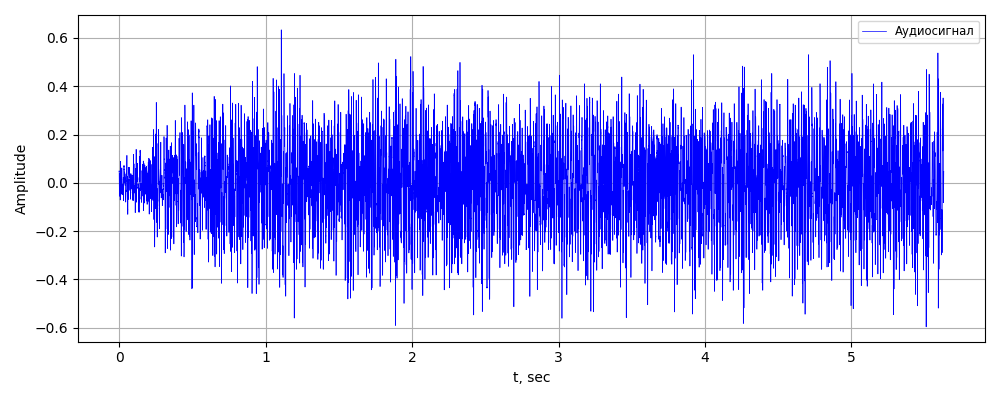

In [16]:
time = np.linspace(0, len(y) / sr, num=len(y))

subplot_data = [[[
    [time],
    [y],
    ["Аудиосигнал"],
    "t, sec",
    "Amplitude",
    ["blue"],
    ["-"],
    [0.5]
]]]

draw_plots(rows=1, cols=1, width=10, height=4, subplot_data=subplot_data)

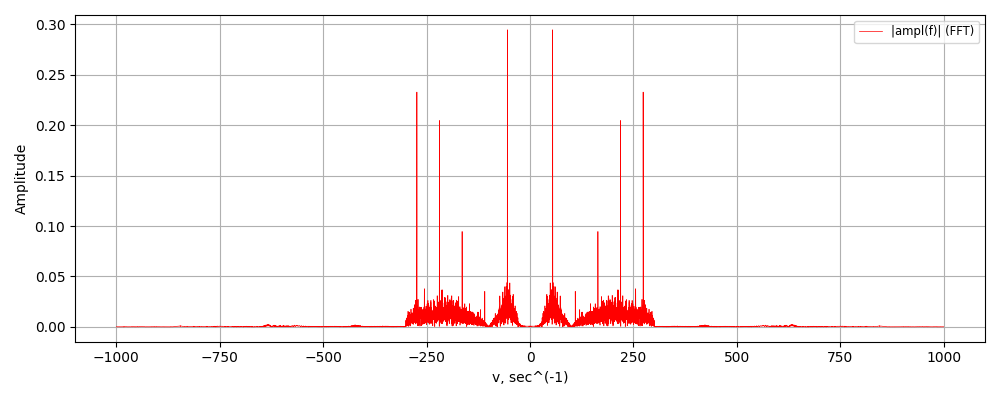

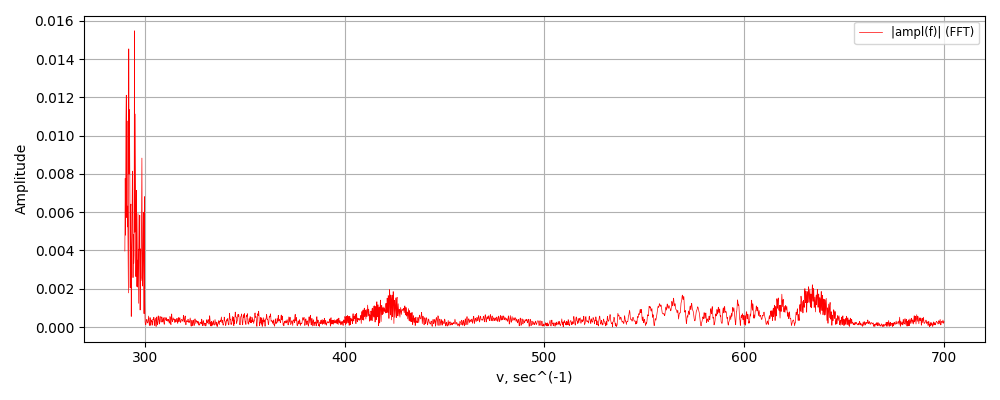

In [17]:
V = 8000
dv = 1
v = np.arange(0, V + dv, dv)

N = len(y)
dt = time[1] - time[0]
ampl_fft = fftshift(fft(y, n=N)) * dt
freqs = fftshift(fftfreq(N, d=dt))

freq_mask = (abs(freqs) < 1000)
freqs_pos = freqs[freq_mask]
ampl_pos = ampl_fft[freq_mask]
subplot_data = [[[
    [freqs_pos], [np.abs(ampl_pos)],
    ["|ampl(f)| (FFT)"],
    "v, sec^(-1)", "Amplitude",
    ["red"], ["-"], [0.5]
]]]

draw_plots(rows=1, cols=1, width=10, height=4, subplot_data=subplot_data)

freq_mask = (freqs < 700) & (freqs > 290)
freqs_pos = freqs[freq_mask]
ampl_pos = ampl_fft[freq_mask]
subplot_data = [[[
    [freqs_pos], [np.abs(ampl_pos)],
    ["|ampl(f)| (FFT)"],
    "v, sec^(-1)", "Amplitude",
    ["red"], ["-"], [0.5]
]]]

draw_plots(rows=1, cols=1, width=10, height=4, subplot_data=subplot_data)

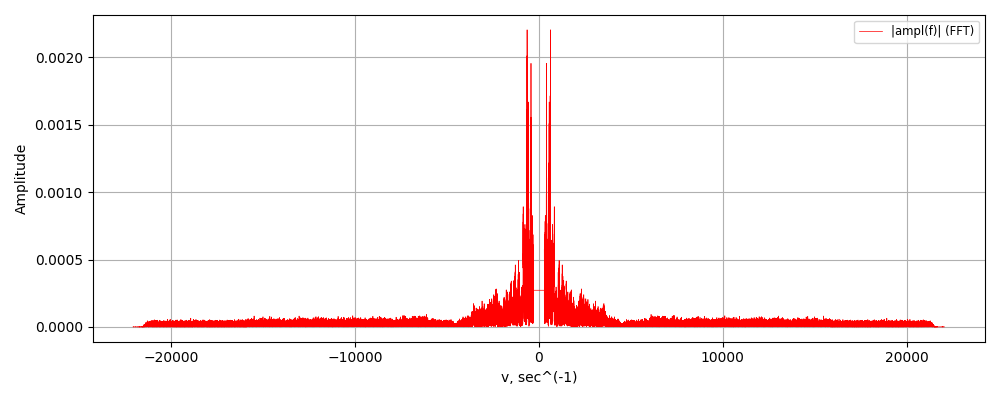

In [18]:
freq_mask = (abs(freqs) > 300)
freqs_pos = freqs[freq_mask]
ampl_pos = ampl_fft[freq_mask]

subplot_data = [[[
    [freqs_pos], [np.abs(ampl_pos)],
    ["|ampl(f)| (FFT)"],
    "v, sec^(-1)", "Amplitude",
    ["red"], ["-"], [0.5]
]]]

draw_plots(rows=1, cols=1, width=10, height=4, subplot_data=subplot_data)

In [19]:

filtered_fft = np.zeros_like(ampl_fft)
filtered_fft[freq_mask] = ampl_fft[freq_mask]

y_filtered = np.real(ifft(ifftshift(filtered_fft)))[:len(y)]

y_filtered_normalized = y_filtered / np.max(np.abs(y_filtered))
sf.write('MUHA_filtered.wav', y_filtered_normalized, sr)